<a href="https://colab.research.google.com/github/hhtnghia321/PPCA---project---Group-NNNV/blob/master/fillna_with_PPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
oridata_source = 'https://drive.google.com/u/1/uc?id=1iDCKJQbhoIp23YYZSmxRjub2b91TQmzJ&export=download'
dataNA_source = 'https://drive.google.com/u/1/uc?id=1cz7oJ0BJR5rzH1dVTtq2SJPdhxFEYs9o&export=download'
data_fillNA_source = 'https://drive.google.com/u/1/uc?id=1c6AAacF2piMdrvv6ZU5AwIHwXOo7xvJS&export=downloadd'
pos_of_true_values = 'https://drive.google.com/u/1/uc?id=1B7VOB_qM08uRHWLFvhyd9Hq95CN0OcMz&export=download'

In [0]:
import numpy as np
import random
import pandas as pd

In [0]:
names = ['Sample_code_number', 'Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape',
        'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei',
        'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses', 'Class']
ori_data = pd.read_csv(oridata_source, names=names, index_col = False, na_values = '?')
ori_data.fillna(round(ori_data.mean()), inplace = True)
mean_ori_data = ori_data.mean()[1:-1]
ori_data = ori_data.drop(columns=['Sample_code_number', 'Class']).values

In [4]:
names_ = ['Index', 'Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape',
        'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei',
        'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses']
data = pd.read_csv(data_fillNA_source, index_col = False, names= names_)
data.shape
data = data.iloc[:,1:].values
print(data.shape)

(699, 9)


###Fill na with position matrix

In [0]:
def fillna_with_posmatrix(data_miss, data, pos_ma):
    data_miss = np.array(data_miss)
    data = np.array(data)
    pos_ma = np.array(pos_ma)
    indeces = np.where(pos_ma == True)
    data_miss[indeces] = data[indeces]
    return data_miss

### Probabilistic PPCA function

In [0]:
def PPCA1(data, q, sigma_init = 1, EM = False, pos_na = None): #pos_na là ma trận chứa vị trí của missing value
    N = data.shape[0]  # N row, N t_i
    d = data.shape[1]  # d cột của data
    mean = np.mean(data.T, axis=1) # mean vector
    mean = np.array([mean]).T # chuyển vecto mean về vecto cột
    if EM == False and pos_na == None: #vì MLE không nhận được missing value
      S = (data.T -  mean).dot((data.T -  mean).T) / N # hiệp phương sai sample S
      eig_vals, eig_vecs = np.linalg.eig(S) # hàm riêng và trị riêng của S
      # xếp các trị riêng hàm riêng tương ứng thành các tuple
      eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
      # xếp lại theo thứ tự theo giá trị trị riêng
      eig_pairs.sort() 
      eig_pairs.reverse()
      # tìm MLE cho lambda
      lambda_ = 0
      for i in range(q, d):
        lambda_ += eig_pairs[i][0]
      sigma_ML = 1/(d-q)*lambda_
      # tìm ma trận U_q
      U_q = eig_pairs[0][1]
      for i in range(1, q):
        U_q = np.vstack((U_q, eig_pairs[i][1]))
      U_q = U_q.T
      # tìm ma trận Delta_q
      eig_vals_for_delta = np.array(eig_pairs[0][0])
      for i in range(1, q):
        eig_vals_for_delta = np.append(eig_vals_for_delta, eig_pairs[i][0])
      Delta_q = np.diag((eig_vals_for_delta))
      # tính ma trận W với giả định R = I
      W = np.matrix.round( U_q.dot(  np.sqrt(Delta_q - sigma_ML*np.identity(q)) ), 2 )
    else:
        sigma = sigma_init 
        W = np.random.rand(d, q)
        while True:
            S = (data.T -  mean).dot((data.T -  mean).T) / N # hiệp phương sai sample S
            M = W.T.dot(W) + sigma * np.identity(q)
            M_inv = np.linalg.inv(M)    
            W_ml = S.dot(W).dot(np.linalg.inv(sigma*np.identity(q) + M_inv.dot(W.T).dot(S).dot(W)))
            sigma_ML = (1/d) * np.trace(S - S.dot(W).dot(M_inv).dot(W_ml.T))
            sigma_ML = np.absolute(sigma_ML)
            if abs((sigma - sigma_ML)) <= 0.1:
                break
            W = W_ml
            sigma = sigma_ML
            #if pos_na != None:
                #WtW_inv = np.linalg.inv(W.T.dot(W))
                #data_hat = W.dot(WtW_inv).dot(W.T).dot(data.T).T
                #data = fillna_with_posmatrix(data, data_hat, pos_na)
    return (W, sigma_ML, mean, data)

In [6]:
W_ML = PPCA(data, 2, EM=True)
W = W_ML[0]
t_n = (W.dot(np.linalg.inv(W.T.dot(W))).dot(W.T).dot(data.T)).T
#t_n = t_n.T
t_n.shape

(699, 9)

In [7]:
ori_data

array([[ 5.,  1.,  1., ...,  3.,  1.,  1.],
       [ 5.,  4.,  4., ...,  3.,  2.,  1.],
       [ 3.,  1.,  1., ...,  3.,  1.,  1.],
       ...,
       [ 5., 10., 10., ...,  8., 10.,  2.],
       [ 4.,  8.,  6., ..., 10.,  6.,  1.],
       [ 4.,  8.,  8., ..., 10.,  4.,  1.]])

In [8]:
pos = pd.read_csv(pos_of_true_values, index_col=False)
pos = pos.iloc[:, 1:]
pos.iloc[:, 0]
result_ML = [] 
result_mean = []
for i in range(0, pos.shape[1]):
  error_ML = []
  error_mean = []
  for item in pos.iloc[:, i]:
    error_ML.append((ori_data[item,i] - t_n[item,i])**2)
    error_mean.append((ori_data[item,i] - mean_ori_data[i])**2)
  result_ML.append((sum(error_ML)/50)**0.5)
  result_mean.append((sum(error_mean)/50)**0.5)

print(result_ML)
print(result_mean)


[2.773287625396221, 1.3043938077268507, 1.545238478360944, 1.5849731831397584, 1.931062761135311, 2.9494234644365998, 1.696274989649703, 2.3615497896336115, 1.174058503169452]
[2.945853751027545, 3.0741436146760237, 2.8817562112352446, 2.4285418249196296, 2.4269644805677304, 2.8942028113456657, 2.339117217762626, 3.21688441461498, 1.1197143134556156]


##Compared Calculation between MLE (closed form) and EM algorithm for PCA


In [9]:
%time 
EM = PPCA(data, 3, EM=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs


In [10]:
%time 
MLE = PPCA(data, 3)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


##Compare PCA with PPCA (with missing value)
*in this section, we try to illustrate how good EM of PPCA to reconduct missing value

In [109]:
from sklearn.decomposition import  PCA
pca= PCA(2, random_state=2020)
pca.fit(data)
pca_comps = pca.components_
pca_data = pd.DataFrame(pca_comps.dot(data.transpose()).transpose())
pca_data

,0,1
0,4.907832,0.216081
1,11.566675,-5.228271
2,5.057733,-0.440343
3,14.464847,3.418346
4,5.276080,0.268428
...,...,...
694,5.214952,0.149614
695,4.096269,0.359210
696,16.849735,6.240454
697,14.592020,2.478905


In [110]:
data_miss = pd.read_csv(dataNA_source,na_values="?")
pos_na = pd.isna(data_miss).iloc[:,1:].values
data_miss1 = data_miss.iloc[:,1:].values
data_miss_filled = data_miss.fillna(0).iloc[:,1:].values
ppca_miss = PPCA1(data_miss_filled, 2,EM=True,pos_na= pos_na)
ppca_comp_miss = ppca_miss[0].T
data_compl = ppca_miss[3]
ppca_data_miss = pd.DataFrame(ppca_comp_miss.dot(data_compl.T).T)
ppca_data_miss


,0,1
0,9.842203,20.171754
1,21.584772,55.073616
2,10.411160,20.753501
3,34.885698,57.239074
4,11.366755,21.173386
...,...,...
694,9.610780,19.290597
695,7.754750,13.843449
696,49.764842,71.603812
697,39.483807,61.960652


In [116]:
ppca_miss = PPCA1(data, 2)
ppca_comp_miss = ppca_miss[0].T
data_compl = ppca_miss[3]
ppca_data_miss = pd.DataFrame(ppca_comp_miss.dot(data_compl.T).T)
ppca_data_miss


,0,1
0,31.12,0.36
1,73.32,-8.49
2,32.05,-0.70
3,91.68,5.56
4,33.45,0.45
...,...,...
694,33.06,0.24
695,25.97,0.59
696,106.81,10.15
697,92.47,4.06


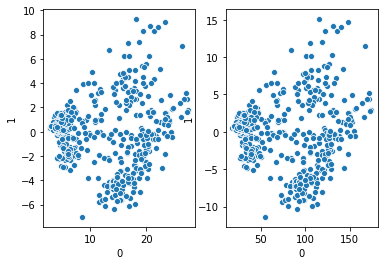

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
sns.scatterplot(x = 0, y = 1, data= pca_data)

plt.subplot(1,2,2)
sns.scatterplot(x = 0, y = 1, data= ppca_data_miss)

In [102]:
data

array([[ 5.,  1.,  1., ...,  3.,  1.,  1.],
       [ 5.,  4.,  4., ...,  3.,  2.,  1.],
       [ 3.,  1.,  3., ...,  3.,  1.,  1.],
       ...,
       [ 5., 10.,  3., ...,  8., 10.,  2.],
       [ 4.,  8.,  3., ..., 10.,  6.,  1.],
       [ 4.,  8.,  8., ..., 10.,  4.,  1.]])